In [7]:
import numpy as np
import pandas as pd
from pickle import dump
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from itertools import product
import json

from sklearn.metrics import mean_squared_error

In [8]:
data_sent = pd.read_csv('data/data_sentiment.csv')

### Analysis of dataset

In [9]:
sum([True if 'tsla' in i.lower() or '@tesla' in i.lower() or '$tesla' in i.lower() else False for i in data_sent['Tweet']])


44112

In [10]:
# tsla = data_sent[data_sent["Stock Name"] == 'TSLA']['Tweet']
# print(len(tsla))
# iter = [True if 'tsla' in i.lower() or '@tesla' in i.lower() or '$tesla' in i.lower() else False for i in data_sent['Tweet']]
# for n,i in enumerate(iter):
#     if not i:
#         print(tsla[n])

In [11]:
# for tweet, stock in zip(data_sent['Tweet'],data_sent['Stock Name']):
#     if 'tesla' in tweet.lower() and stock != 'TSLA':
#         print(tweet)

Conclusions:
- Stocks are being picked based on name of the company or stock ticker
- If a twitter post discusses more than one stock then column "Stock name" is empty

### Actual prediction

In [12]:
prices_hist = pd.read_csv('data/stock_yfinance_data.csv')

In [13]:
data_sent

,Date,Tweet,Stock Name,Company Name,positive,neutral,negative
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",0.0573,0.2339,0.7088
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",0.3148,0.6753,0.0099
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",0.0785,0.8904,0.0311
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",0.0120,0.0724,0.9156
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",0.0052,0.0452,0.9497
...,...,...,...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.,0.9481,0.0486,0.0033
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.,0.4226,0.5692,0.0082
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,XPEV,XPeng Inc.,0.9137,0.0832,0.0031
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.,0.9433,0.0543,0.0024


In [14]:
prices_hist

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...
6295,2022-09-23,13.090000,13.892000,12.860000,13.710000,13.710000,28279600,XPEV
6296,2022-09-26,14.280000,14.830000,14.070000,14.370000,14.370000,27891300,XPEV
6297,2022-09-27,14.580000,14.800000,13.580000,13.710000,13.710000,21160800,XPEV
6298,2022-09-28,13.050000,13.421000,12.690000,13.330000,13.330000,31799400,XPEV


In [15]:
prices_hist['Stock Name'].unique()

array(['TSLA', 'MSFT', 'PG', 'META', 'AMZN', 'GOOG', 'AMD', 'AAPL',
       'NFLX', 'TSM', 'KO', 'F', 'COST', 'DIS', 'VZ', 'CRM', 'INTC', 'BA',
       'BX', 'NOC', 'PYPL', 'ENPH', 'NIO', 'ZS', 'XPEV'], dtype=object)

In [16]:
data_sent['Date'] = pd.to_datetime(data_sent['Date'])  # Convert 'Date' column to datetime

data_sent['Day'] = data_sent['Date'].dt.date 

In [17]:
data_sent.drop(columns=['Date','Tweet', 'Company Name'], inplace=True)

In [18]:
def df_for_inp(data, prices, ticker : str):

    data = data[data['Stock Name'] == ticker]
    data = data.drop(columns=['Stock Name'], inplace = False)
    twitter_df = data.groupby('Day').mean()
    twitter_df['Date'] = twitter_df.index
    twitter_df = twitter_df.reset_index(drop=True)

    prices['Date'] = pd.to_datetime(prices['Date'])
    prices = prices[prices['Stock Name'] == ticker]

    twitter_df['Date'] = pd.to_datetime(twitter_df['Date'])

    df = pd.merge(twitter_df, prices, on='Date', how='inner')

    df = df[df['Stock Name'] == ticker]

    df = df.sort_values(by='Date')
    df = df.drop(columns='Date')
    df = df.drop(columns='Stock Name')

    return df

In [19]:
df_for_inp(data_sent, prices_hist, 'TSLA')

,positive,neutral,negative,Open,High,Low,Close,Adj Close,Volume
0,0.352172,0.433046,0.214780,260.333344,263.043335,258.333344,258.493347,258.493347,53868000
1,0.412740,0.414943,0.172319,259.466675,260.260010,254.529999,258.406677,258.406677,51094200
2,0.364087,0.436857,0.199058,265.500000,268.989990,258.706665,260.510010,260.510010,91449900
3,0.387511,0.394376,0.218107,261.600006,265.769989,258.066681,260.196655,260.196655,55297800
4,0.397635,0.418137,0.184232,258.733337,262.220001,257.739990,260.916656,260.916656,43898400
...,...,...,...,...,...,...,...,...,...
247,0.438738,0.374231,0.187038,283.089996,284.500000,272.820007,275.329987,275.329987,63748400
248,0.417667,0.375392,0.206940,271.829987,284.089996,270.309998,276.010010,276.010010,58076900
249,0.467805,0.357291,0.174904,283.839996,288.670013,277.510010,282.940002,282.940002,61925200
250,0.471717,0.347468,0.180812,283.079987,289.000000,277.570007,287.809998,287.809998,54664800


In [20]:
def split_train_test(data, test_size : int):
    train_size = len(data) - test_size
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [21]:
def split_X_y(df, target_column, train : bool, sent : bool):
    
    target_df_series = pd.DataFrame(df[target_column])
    
    if train:
        data = pd.DataFrame(df.iloc[:, :])
    else:
        data = df[['positive', 'negative', 'neutral']]

    if sent is False:
        data = df.drop(columns=['positive', 'negative', 'neutral'])

    return data, target_df_series

def normalize_data(X, y, range):

    '''
    df: dataframe object
    range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
    target_column: type str -> should reflect closing price of stock
    '''
    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(X)
    y_scaler.fit(y)

    X_scale_dataset = X_scaler.fit_transform(X)
    y_scale_dataset = y_scaler.fit_transform(y)
    
    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset,y_scaler)

In [22]:
def rmse_out(predictions, test_y):
    # determine rmse

    # For regression problems
    mse = mean_squared_error(predictions, test_y)
    mae = mean_absolute_error(predictions, test_y)
    rmse = np.sqrt(mse)
    return mse, mae

In [23]:
def plot(predictions, test_y, ticker):
    
    #test_y = [i[4] for i in test_y]
    # Plotting the two series
    plt.plot(predictions, label='Predicted')
    plt.plot(test_y, label='Test')

    # Adding labels and title
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title(f'Prediction of {ticker}')

    # Adding legend
    plt.legend()

    # Displaying the plot
    plt.show()

In [24]:
def reflect_along_x_axis(array, first_value):
    # Get the y-coordinate of the first value of the prediction array
    y_intercept = first_value
    
    # Reflect the array along the x-axis at this y-coordinate
    reflected_array = 2 * y_intercept - array
    
    return reflected_array


def plot_predictions(test_y_actual, predictions, random_walk, ticker):
    plt.figure(figsize=(14, 7))
    
    # Flatten the arrays for easier plotting
    #test_y_flat = reflect_along_x_axis(test_y_actual.reset_index(drop=True), list(test_y_actual.reset_index(drop=True)['Close'].to_numpy())[0])
    test_y_flat = test_y_actual
    predictions_flat = predictions

    plt.plot(random_walk, color='green', label='Random Walk')
    
    # Plotting the actual values
    plt.plot(test_y_flat, color='blue', label='Actual Prices')
    
    # Plotting the predicted values
    plt.plot(predictions_flat, color='red', linestyle='--', label='Predicted Prices')
    
    # Adding title and labels
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

### Baseline model

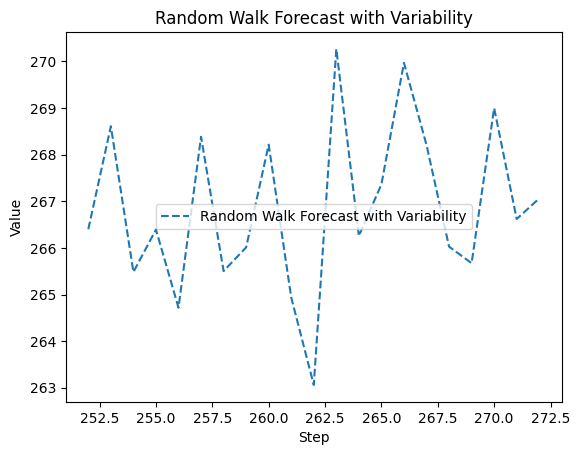

In [25]:
def random_walk_forecast(history, n_steps, variability_factor=0.05):
    """
    Generate a random walk forecast with variability.

    Parameters:
        history (array-like): Array containing the historical values of the time series.
        n_steps (int): Number of steps to forecast into the future.
        variability_factor (float): Factor controlling the amount of variability in the forecast.

    Returns:
        array: Array containing the forecasted values.
    """
    forecast = []
    for _ in range(n_steps):
        # Generate a random noise term
        noise = np.random.normal(loc=0, scale=variability_factor * np.std(history))
        # Add noise to the last observed value
        forecast.append(history[-1] + noise)
    return np.array(forecast)

# Example usage
# Assuming 'prices_hist' is your time series data
# Let's say you want to forecast 30 days into the future
n_steps = 21
history = prices_hist[prices_hist['Stock Name'] == 'TSLA']['Close'].values.astype(float)  # Assuming 'Close' is the column containing the time series data

# Make the forecast with some variability (adjust variability_factor as needed)
variability_factor = 0.05  # Adjust this parameter to control the amount of variability
forecast = random_walk_forecast(history, n_steps, variability_factor)

# Generate integers for the x-axis
x_values = np.arange(len(history), len(history) + n_steps)

# Plotting
plt.plot(x_values, forecast, label='Random Walk Forecast with Variability', linestyle='--')
plt.xlabel('Step')
plt.ylabel('Value')
plt.title('Random Walk Forecast with Variability')
plt.legend()
plt.show()


### Recursive prediction

In [26]:
def train(data, ticker : str):

    tsl_train, tsl_test = split_train_test(data, 20)

    tsl_train_x, tsl_train_y = split_X_y(tsl_train, 'Close', True, True)
    tsl_test_x, tsl_test_y = split_X_y(tsl_test, 'Close', True, True)

    tsl_train_x, tsl_train_y, y_scaler_train =  normalize_data(tsl_train_x, tsl_train_y, (-1,1))
    tsl_test_x, tsl_test_y, y_scaler_test =  normalize_data(tsl_test_x, tsl_test_y, (-1,1))

    print(tsl_train_x.shape)
    print(tsl_train_y.shape)

    # Define LSTM model
    model = Sequential([
        LSTM(units=200, return_sequences=True, input_shape=(tsl_train_x.shape[1], 1)),
        LSTM(units=200, return_sequences=True, input_shape=(tsl_train_x.shape[1], 1)),
        LSTM(units=50, return_sequences=True, input_shape=(tsl_train_x.shape[1], 1)),
        LSTM(units=50, return_sequences=False),
        Dense(units=25),
        Dense(units=1)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(tsl_train_x, tsl_train_y, epochs=8, batch_size=32)

    # Perform one-step ahead forecasting for 20 days
    y_pred = one_step_ahead_forecasting(model, tsl_test_x)

    # Inverse scale the predictions
    predictions = y_scaler_test.inverse_transform(np.array(y_pred).reshape(-1, 1))

    test_y = y_scaler_test.inverse_transform(tsl_test_y)

    return predictions, test_y

# Adjusted function for one-step ahead forecasting for 20 days
def one_step_ahead_forecasting(model, X_test):
    """
    Perform one-step ahead forecasting for 20 days.

    Parameters:
    - model: Trained LSTM model.
    - X_test: Test data in the shape (samples, time steps, features).

    Returns:
    - y_pred: Predicted stock prices for the next 20 days.
    """

    y_pred = []
    X_current = X_test[0]  # Start with the first data point in the test set

    for i in range(20):
        # Select only the relevant features for prediction
        X_current_pred = X_current
        # Predict the next value
        pred = model.predict(np.array([X_current_pred]))
        y_pred.append(pred[0])

        print(X_current)
        print(X_current[1:])
        print(pred)
        # Update X_current by appending the predicted value and removing the first element
        X_current = pred[0]

    return y_pred

In [ ]:
mses = []
for i in range(10):
    ticker = 'TSLA'
    predictions, test_y = train(df_for_inp(data_sent, prices_hist, 'TSLA'), ticker)
    mse = rmse_out(predictions, test_y)
    print(f'rmse: {mse}')
    mses.append(mse)
    # plot(predictions, test_y, ticker)
    predictions = predictions[:len(test_y)]  # Align lengths if necessary
    plot_predictions(test_y, predictions, test_y, ticker)

print(sum([i[1] for i in mses])/10)


### Sliding Window (Rolling Window) Method

In [31]:
def create_dataset(x, y, window_size, prediction_length):
    X, Y = [], []
    for i in range(len(x) - window_size - prediction_length + 1):
        X.append(x[i:(i + window_size)])
        Y.append(y[(i + window_size):(i + window_size + prediction_length)])
    return np.array(X), np.array(Y)

In [32]:
def normalize_data(train_X, train_y, test_X, test_y):
    num_train_samples, num_time_steps, num_features = train_X.shape
    num_test_samples = test_X.shape[0]
    num_prediction_steps = train_y.shape[1]

    train_X_2d = train_X.reshape(num_train_samples * num_time_steps, num_features)
    test_X_2d = test_X.reshape(num_test_samples * num_time_steps, num_features)

    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    train_X_scaled = scaler_X.fit_transform(train_X_2d).reshape(num_train_samples, num_time_steps, num_features)
    test_X_scaled = scaler_X.transform(test_X_2d).reshape(num_test_samples, num_time_steps, num_features)
    
    train_y_2d = train_y.reshape(num_train_samples, num_prediction_steps)
    test_y_2d = test_y.reshape(num_test_samples, num_prediction_steps)
    
    train_y_scaled = scaler_y.fit_transform(train_y_2d)
    test_y_scaled = scaler_y.transform(test_y_2d)

    return train_X_scaled, train_y_scaled, test_X_scaled, test_y_scaled, scaler_y

In [33]:
def permutation_importance(model, X, y, metric=mean_squared_error):
    baseline_score = metric(y, model.predict(X))
    importances = []
    for i in range(X.shape[2]):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, :, i])
        permuted_score = metric(y, model.predict(X_permuted))
        importances.append(permuted_score - baseline_score)
    return np.array(importances)

In [34]:
def train(data, prices, ticker, window_size=10, prediction_length=1, lstm_units=50, batch_size=32, dropout_rate=0.0, predict_days=5, sent=True):
    df = df_for_inp(data, prices, ticker)
    
    tsl_train, tsl_test = split_train_test(df, predict_days)
    train_X, train_y = split_X_y(tsl_train, 'Close', True, sent)
    test_X, test_y = split_X_y(tsl_test, 'Close', True, sent)
    
    tsl_train_x, tsl_train_y = create_dataset(train_X, train_y, window_size, prediction_length)
    tsl_test_x, tsl_test_y = create_dataset(test_X, test_y, window_size, prediction_length)
    
    tsl_train_x, tsl_train_y, tsl_test_x, tsl_test_y, y_scaler = normalize_data(
        tsl_train_x, tsl_train_y, tsl_test_x, tsl_test_y)

    model = Sequential([
        LSTM(units=lstm_units, return_sequences=True, input_shape=(window_size, tsl_train_x.shape[2])),
        Dropout(rate=dropout_rate),
        LSTM(units=lstm_units, return_sequences=True),
        Dropout(rate=dropout_rate),
        LSTM(units=lstm_units, return_sequences=False),
        Dropout(rate=dropout_rate),
        Dense(units=25),
        Dense(units=prediction_length)
    ])
    
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model.fit(tsl_train_x, tsl_train_y, epochs=100, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])

    # Assuming X_test and y_test are your test data
    importances = permutation_importance(model, tsl_test_x, tsl_test_y)

        
    predictions = model.predict(tsl_test_x)
    predictions = y_scaler.inverse_transform(predictions)
    tsl_test_y = y_scaler.inverse_transform(tsl_test_y)

    return predictions, test_y, test_X, importances

In [35]:
# Function to append results to JSON file
def append_to_json(file_path, data):
    with open(file_path, 'a') as f:
        f.write(json.dumps(data) + '\n')

Training with window_size=10, prediction_length=15, lstm_units=50, batch_size=32, dropout_rate=0.0, predict_day=20
30


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step - loss: 0.4135 - val_loss: 0.0086
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2676 - val_loss: 0.0168
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0930 - val_loss: 0.0558
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0639 - val_loss: 0.0283
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0442 - val_loss: 0.0126
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0412 - val_loss: 0.0090
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0272 - val_loss: 0.0053
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0293 - val_loss: 0.0039
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0289 - val_loss: 0.0037
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0289 - val_loss: 0.0039
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0250 - val_loss: 0.0053
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0210 - val_l

c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.4124 - val_loss: 0.0104
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2849 - val_loss: 0.0138
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1573 - val_loss: 0.0211
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0973 - val_loss: 0.0120
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0486 - val_loss: 0.0145
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0362 - val_loss: 0.0118
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0337 - val_loss: 0.0063
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0320 - val_loss: 0.0049
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0238 - val_loss: 0.0044
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0262 - val_loss: 0.0044
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0264 - val_loss: 0.0048
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0269 - val_loss: 0.0055


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.3627 - val_loss: 0.0569
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1939 - val_loss: 0.0401
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1097 - val_loss: 0.0296
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0679 - val_loss: 0.0227
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0455 - val_loss: 0.0163
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0375 - val_loss: 0.0294
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0340 - val_loss: 0.0350
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0329 - val_loss: 0.0481
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0294 - val_loss: 0.0479
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0270 - val_loss: 0.0490
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0306 - val_loss: 0.0404
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0292 - val_loss: 0.0406


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - loss: 0.3809 - val_loss: 0.0732
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2507 - val_loss: 0.0526
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1573 - val_loss: 0.0326
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0942 - val_loss: 0.0204
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0550 - val_loss: 0.0192
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0396 - val_loss: 0.0242
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0318 - val_loss: 0.0324
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0325 - val_loss: 0.0338
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0338 - val_loss: 0.0394
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0315 - val_loss: 0.0361
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0282 - val_loss: 0.0373
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0288 - val_loss: 0.0359


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 0.3692 - val_loss: 0.1639
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1882 - val_loss: 0.0584
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0944 - val_loss: 0.0468
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0571 - val_loss: 0.0274
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0457 - val_loss: 0.0209
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0375 - val_loss: 0.0297
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0360 - val_loss: 0.0300
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0360 - val_loss: 0.0467
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0364 - val_loss: 0.0446
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0353 - val_loss: 0.0490
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0337 - val_loss: 0.0433
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0353 - val_loss: 0.0495


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 0.3595 - val_loss: 0.2034
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2481 - val_loss: 0.0883
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1158 - val_loss: 0.0366
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0663 - val_loss: 0.0394
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0476 - val_loss: 0.0228
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0422 - val_loss: 0.0317
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0395 - val_loss: 0.0402
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0375 - val_loss: 0.0360
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0364 - val_loss: 0.0442
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0347 - val_loss: 0.0369
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0366 - val_loss: 0.0468
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0352 - val_loss: 0.0394


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.3758 - val_loss: 0.0273
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2629 - val_loss: 0.0515
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1606 - val_loss: 0.0360
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0865 - val_loss: 0.0283
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0533 - val_loss: 0.0241
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0401 - val_loss: 0.0125
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0320 - val_loss: 0.0125
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0320 - val_loss: 0.0171
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0301 - val_loss: 0.0132
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0277 - val_loss: 0.0122
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0263 - val_loss: 0.0101
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0271 - val_loss: 0.0098


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.3939 - val_loss: 0.0227
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2402 - val_loss: 0.0246
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0999 - val_loss: 0.0189
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0500 - val_loss: 0.0183
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0395 - val_loss: 0.0137
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0347 - val_loss: 0.0092
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0329 - val_loss: 0.0090
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0301 - val_loss: 0.0104
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0299 - val_loss: 0.0106
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0273 - val_loss: 0.0106
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0259 - val_loss: 0.0107
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0286 - val_loss: 0.0106


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - loss: 0.2607 - val_loss: 0.0048
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1515 - val_loss: 0.0213
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0751 - val_loss: 0.0132
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0530 - val_loss: 0.0068
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0330 - val_loss: 0.0038
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0194 - val_loss: 0.0059
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0154 - val_loss: 0.0086
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0151 - val_loss: 0.0105
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0138 - val_loss: 0.0085
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0145 - val_loss: 0.0065
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0125 - val_loss: 0.0047
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0118 - val_loss: 0.0041


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - loss: 0.3099 - val_loss: 0.0025
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1704 - val_loss: 0.0062
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0943 - val_loss: 0.0092
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0472 - val_loss: 0.0042
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0349 - val_loss: 0.0028
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0249 - val_loss: 0.0021
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0204 - val_loss: 0.0021
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0154 - val_loss: 0.0029
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0150 - val_loss: 0.0040
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0130 - val_loss: 0.0050
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0131 - val_loss: 0.0053
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0122 - val_loss: 0.0049


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - loss: 0.4136 - val_loss: 0.0085
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2397 - val_loss: 0.0274
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1179 - val_loss: 0.0455
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0753 - val_loss: 0.0209
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0460 - val_loss: 0.0144
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0349 - val_loss: 0.0062
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0297 - val_loss: 0.0050
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0280 - val_loss: 0.0045
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0293 - val_loss: 0.0042
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0270 - val_loss: 0.0046
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0280 - val_loss: 0.0054
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0250 - val_loss: 0.0066


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - loss: 0.3959 - val_loss: 0.0099
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2868 - val_loss: 0.0084
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1640 - val_loss: 0.0272
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1022 - val_loss: 0.0202
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0642 - val_loss: 0.0150
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0492 - val_loss: 0.0144
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0363 - val_loss: 0.0092
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0261 - val_loss: 0.0064
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0274 - val_loss: 0.0054
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0254 - val_loss: 0.0051
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0237 - val_loss: 0.0048
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0279 - val_loss: 0.0050


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.3631 - val_loss: 0.0626
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2193 - val_loss: 0.0505
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1544 - val_loss: 0.0262
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0805 - val_loss: 0.0161
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0463 - val_loss: 0.0226
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0325 - val_loss: 0.0425
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0307 - val_loss: 0.0612
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0301 - val_loss: 0.0551
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0308 - val_loss: 0.0522
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0293 - val_loss: 0.0385
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0267 - val_loss: 0.0387
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0271 - val_loss: 0.0344


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 0.3567 - val_loss: 0.0671
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2158 - val_loss: 0.0405
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1145 - val_loss: 0.0306
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0597 - val_loss: 0.0200
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0394 - val_loss: 0.0249
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0355 - val_loss: 0.0293
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0314 - val_loss: 0.0348
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0312 - val_loss: 0.0388
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0270 - val_loss: 0.0411
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0291 - val_loss: 0.0379
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0269 - val_loss: 0.0386
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0285 - val_loss: 0.0369


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - loss: 0.3651 - val_loss: 0.1989
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2249 - val_loss: 0.0959
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1083 - val_loss: 0.0365
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0562 - val_loss: 0.0224
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0513 - val_loss: 0.0204
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0409 - val_loss: 0.0331
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0378 - val_loss: 0.0438
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0338 - val_loss: 0.0469
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0342 - val_loss: 0.0508
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0335 - val_loss: 0.0508
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0329 - val_loss: 0.0558
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0331 - val_loss: 0.0455

c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 320ms/step - loss: 0.3454 - val_loss: 0.1721
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1647 - val_loss: 0.0583
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0863 - val_loss: 0.0414
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0587 - val_loss: 0.0345
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0450 - val_loss: 0.0258
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0397 - val_loss: 0.0375
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0383 - val_loss: 0.0380
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0357 - val_loss: 0.0384
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0332 - val_loss: 0.0490
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0360 - val_loss: 0.0474
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0352 - val_loss: 0.0476
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0336 - val_loss: 0.0508


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.4024 - val_loss: 0.0249
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2748 - val_loss: 0.0418
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1435 - val_loss: 0.0401
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0679 - val_loss: 0.0346
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0519 - val_loss: 0.0183
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0342 - val_loss: 0.0107
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0323 - val_loss: 0.0121
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0274 - val_loss: 0.0161
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0299 - val_loss: 0.0121
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0287 - val_loss: 0.0107
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0287 - val_loss: 0.0099
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0289 - val_loss: 0.0091


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.3939 - val_loss: 0.0245
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2441 - val_loss: 0.0284
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1099 - val_loss: 0.0236
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0718 - val_loss: 0.0149
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0561 - val_loss: 0.0152
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0418 - val_loss: 0.0106
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0318 - val_loss: 0.0094
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0300 - val_loss: 0.0093
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0340 - val_loss: 0.0096
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0293 - val_loss: 0.0095
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0302 - val_loss: 0.0117
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0302 - val_loss: 0.0103


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - loss: 0.2659 - val_loss: 0.0047
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1339 - val_loss: 0.0330
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0774 - val_loss: 0.0184
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0476 - val_loss: 0.0069
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0323 - val_loss: 0.0033
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0163 - val_loss: 0.0053
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0171 - val_loss: 0.0094
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0152 - val_loss: 0.0111
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0154 - val_loss: 0.0091
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0124 - val_loss: 0.0064
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0119 - val_loss: 0.0049
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0115 - val_loss: 0.0039


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 0.2881 - val_loss: 0.0029
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1861 - val_loss: 0.0054
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1014 - val_loss: 0.0110
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0714 - val_loss: 0.0062
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0465 - val_loss: 0.0036
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0339 - val_loss: 0.0025
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0234 - val_loss: 0.0023
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0164 - val_loss: 0.0031
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0138 - val_loss: 0.0046
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0132 - val_loss: 0.0054
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0125 - val_loss: 0.0056
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0130 - val_loss: 0.0050


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 0.4018 - val_loss: 0.0073
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2285 - val_loss: 0.0337
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0965 - val_loss: 0.0600
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0633 - val_loss: 0.0219
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0519 - val_loss: 0.0106
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0342 - val_loss: 0.0060
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0354 - val_loss: 0.0039
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0272 - val_loss: 0.0041
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0285 - val_loss: 0.0039
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0254 - val_loss: 0.0041
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0255 - val_loss: 0.0045
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0268 - val_loss: 0.0066


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 0.3927 - val_loss: 0.0099
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2933 - val_loss: 0.0102
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1549 - val_loss: 0.0268
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0858 - val_loss: 0.0191
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0520 - val_loss: 0.0179
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0406 - val_loss: 0.0113
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0354 - val_loss: 0.0073
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0277 - val_loss: 0.0052
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0270 - val_loss: 0.0045
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0250 - val_loss: 0.0047
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0265 - val_loss: 0.0047
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0245 - val_loss: 0.0050


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.3941 - val_loss: 0.0627
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2196 - val_loss: 0.0326
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0980 - val_loss: 0.0216
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0642 - val_loss: 0.0224
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0452 - val_loss: 0.0246
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0335 - val_loss: 0.0372
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0295 - val_loss: 0.0408
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0307 - val_loss: 0.0499
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0296 - val_loss: 0.0451
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0309 - val_loss: 0.0447
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0253 - val_loss: 0.0388
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0303 - val_loss: 0.0382


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 0.3409 - val_loss: 0.0557
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1661 - val_loss: 0.0204
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0881 - val_loss: 0.0235
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0597 - val_loss: 0.0237
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0387 - val_loss: 0.0201
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0390 - val_loss: 0.0309
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0312 - val_loss: 0.0303
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0326 - val_loss: 0.0368
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0279 - val_loss: 0.0379
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0279 - val_loss: 0.0414
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0294 - val_loss: 0.0416
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0275 - val_loss: 0.0433


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 0.3860 - val_loss: 0.2014
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2268 - val_loss: 0.0986
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1153 - val_loss: 0.0436
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0677 - val_loss: 0.0338
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0523 - val_loss: 0.0266
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0401 - val_loss: 0.0293
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0352 - val_loss: 0.0434
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0363 - val_loss: 0.0486
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0350 - val_loss: 0.0481
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0325 - val_loss: 0.0521
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0352 - val_loss: 0.0465
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0336 - val_loss: 0.0469


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - loss: 0.3584 - val_loss: 0.1995
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2322 - val_loss: 0.0811
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1098 - val_loss: 0.0387
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0698 - val_loss: 0.0477
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0551 - val_loss: 0.0251
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0403 - val_loss: 0.0345
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0384 - val_loss: 0.0401
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0379 - val_loss: 0.0316
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0366 - val_loss: 0.0433
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0373 - val_loss: 0.0405
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0336 - val_loss: 0.0431
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0342 - val_loss: 0.0397


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.3905 - val_loss: 0.0230
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2370 - val_loss: 0.0332
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1431 - val_loss: 0.0211
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0775 - val_loss: 0.0162
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0460 - val_loss: 0.0104
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0367 - val_loss: 0.0123
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0288 - val_loss: 0.0176
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0284 - val_loss: 0.0202
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0317 - val_loss: 0.0158
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0286 - val_loss: 0.0125
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0254 - val_loss: 0.0114
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0307 - val_loss: 0.0096


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 0.3757 - val_loss: 0.0206
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1965 - val_loss: 0.0366
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0944 - val_loss: 0.0262
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0491 - val_loss: 0.0193
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0483 - val_loss: 0.0157
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0380 - val_loss: 0.0098
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0341 - val_loss: 0.0089
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0315 - val_loss: 0.0101
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0287 - val_loss: 0.0108
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0297 - val_loss: 0.0125
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0300 - val_loss: 0.0113
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0288 - val_loss: 0.0114


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - loss: 0.2727 - val_loss: 0.0034
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1949 - val_loss: 0.0172
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1390 - val_loss: 0.0121
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1013 - val_loss: 0.0049
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0686 - val_loss: 0.0037
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0408 - val_loss: 0.0077
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0222 - val_loss: 0.0123
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0165 - val_loss: 0.0130
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0138 - val_loss: 0.0096
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0153 - val_loss: 0.0056
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0128 - val_loss: 0.0039
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0136 - val_loss: 0.0030


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - loss: 0.2452 - val_loss: 0.0033
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1529 - val_loss: 0.0065
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1221 - val_loss: 0.0024
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0732 - val_loss: 0.0019
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0383 - val_loss: 0.0018
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0242 - val_loss: 0.0034
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0175 - val_loss: 0.0052
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0141 - val_loss: 0.0071
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0162 - val_loss: 0.0071
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0141 - val_loss: 0.0068
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0136 - val_loss: 0.0057
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0140 - val_loss: 0.0049


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.3947 - val_loss: 0.0087
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2401 - val_loss: 0.0239
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1214 - val_loss: 0.0642
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0605 - val_loss: 0.0324
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0523 - val_loss: 0.0163
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0395 - val_loss: 0.0099
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0273 - val_loss: 0.0039
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0298 - val_loss: 0.0037
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0302 - val_loss: 0.0041
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0289 - val_loss: 0.0046
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0246 - val_loss: 0.0076
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0265 - val_loss: 0.0076


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 0.3739 - val_loss: 0.0072
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2148 - val_loss: 0.0208
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1047 - val_loss: 0.0390
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0600 - val_loss: 0.0174
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0515 - val_loss: 0.0162
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0391 - val_loss: 0.0180
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0390 - val_loss: 0.0098
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0294 - val_loss: 0.0064
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0296 - val_loss: 0.0059
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0260 - val_loss: 0.0051
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0258 - val_loss: 0.0046
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0258 - val_loss: 0.0050


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.3918 - val_loss: 0.0685
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2279 - val_loss: 0.0525
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1205 - val_loss: 0.0254
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0684 - val_loss: 0.0153
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0430 - val_loss: 0.0183
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0356 - val_loss: 0.0221
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0321 - val_loss: 0.0332
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0314 - val_loss: 0.0350
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0284 - val_loss: 0.0373
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0312 - val_loss: 0.0309
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0279 - val_loss: 0.0342
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0299 - val_loss: 0.0295


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.3602 - val_loss: 0.0663
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2411 - val_loss: 0.0328
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0972 - val_loss: 0.0176
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0469 - val_loss: 0.0170
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0446 - val_loss: 0.0238
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0331 - val_loss: 0.0302
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0323 - val_loss: 0.0326
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0336 - val_loss: 0.0400
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0312 - val_loss: 0.0373
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0305 - val_loss: 0.0433
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0275 - val_loss: 0.0393
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0276 - val_loss: 0.0401


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.3495 - val_loss: 0.1532
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1645 - val_loss: 0.0400
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0845 - val_loss: 0.0344
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0507 - val_loss: 0.0381
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0419 - val_loss: 0.0278
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0352 - val_loss: 0.0421
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0374 - val_loss: 0.0542
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0350 - val_loss: 0.0428
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0319 - val_loss: 0.0607
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0335 - val_loss: 0.0555
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0320 - val_loss: 0.0561
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0341 - val_loss: 0.0583


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - loss: 0.3588 - val_loss: 0.1772
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1671 - val_loss: 0.0705
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0840 - val_loss: 0.0452
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0501 - val_loss: 0.0386
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0429 - val_loss: 0.0294
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0377 - val_loss: 0.0397
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0361 - val_loss: 0.0354
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0369 - val_loss: 0.0349
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0360 - val_loss: 0.0405
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0347 - val_loss: 0.0361
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0350 - val_loss: 0.0428
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0319 - val_loss: 0.0388


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.3653 - val_loss: 0.0201
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2067 - val_loss: 0.0603
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1368 - val_loss: 0.0231
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0885 - val_loss: 0.0195
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0588 - val_loss: 0.0142
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0443 - val_loss: 0.0092
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0339 - val_loss: 0.0120
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0306 - val_loss: 0.0163
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0297 - val_loss: 0.0125
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0308 - val_loss: 0.0142
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0325 - val_loss: 0.0109
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0254 - val_loss: 0.0105


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.4056 - val_loss: 0.0234
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1912 - val_loss: 0.0328
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1252 - val_loss: 0.0293
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0676 - val_loss: 0.0136
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0511 - val_loss: 0.0158
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0402 - val_loss: 0.0148
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0341 - val_loss: 0.0088
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0348 - val_loss: 0.0090
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0295 - val_loss: 0.0095
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0294 - val_loss: 0.0111
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0294 - val_loss: 0.0104
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0305 - val_loss: 0.0114


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - loss: 0.3098 - val_loss: 0.0038
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2458 - val_loss: 0.0122
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1221 - val_loss: 0.0124
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0688 - val_loss: 0.0031
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0445 - val_loss: 0.0023
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0258 - val_loss: 0.0062
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0173 - val_loss: 0.0107
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0146 - val_loss: 0.0116
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0152 - val_loss: 0.0102
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0128 - val_loss: 0.0076
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0116 - val_loss: 0.0059
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0121 - val_loss: 0.0049


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 225ms/step - loss: 0.2690 - val_loss: 0.0028
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1476 - val_loss: 0.0087
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1069 - val_loss: 0.0066
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0538 - val_loss: 0.0034
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0323 - val_loss: 0.0031
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0256 - val_loss: 0.0020
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0221 - val_loss: 0.0021
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0153 - val_loss: 0.0028
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0138 - val_loss: 0.0043
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0131 - val_loss: 0.0052
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0130 - val_loss: 0.0053
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0134 - val_loss: 0.0050

c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - loss: 0.3434 - val_loss: 0.0132
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1992 - val_loss: 0.0544
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1568 - val_loss: 0.0311
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0865 - val_loss: 0.0176
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0579 - val_loss: 0.0145
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0402 - val_loss: 0.0057
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0325 - val_loss: 0.0051
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0327 - val_loss: 0.0046
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0355 - val_loss: 0.0046
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0273 - val_loss: 0.0054
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0278 - val_loss: 0.0060
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0239 - val_loss: 0.0083


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - loss: 0.3994 - val_loss: 0.0087
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2914 - val_loss: 0.0119
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1397 - val_loss: 0.0300
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0757 - val_loss: 0.0218
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0505 - val_loss: 0.0189
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0387 - val_loss: 0.0132
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0328 - val_loss: 0.0064
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0277 - val_loss: 0.0054
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0265 - val_loss: 0.0047
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0265 - val_loss: 0.0045
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0240 - val_loss: 0.0045
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0243 - val_loss: 0.0048


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - loss: 0.3480 - val_loss: 0.0530
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1493 - val_loss: 0.0312
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0737 - val_loss: 0.0188
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0496 - val_loss: 0.0191
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0402 - val_loss: 0.0197
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0381 - val_loss: 0.0280
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0293 - val_loss: 0.0362
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0312 - val_loss: 0.0411
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0291 - val_loss: 0.0426
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0251 - val_loss: 0.0415
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0285 - val_loss: 0.0386
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0258 - val_loss: 0.0370


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 0.3820 - val_loss: 0.0671
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2211 - val_loss: 0.0270
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0822 - val_loss: 0.0133
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0567 - val_loss: 0.0208
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0387 - val_loss: 0.0227
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0377 - val_loss: 0.0274
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0344 - val_loss: 0.0317
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0294 - val_loss: 0.0367
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0336 - val_loss: 0.0411
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0309 - val_loss: 0.0395
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0263 - val_loss: 0.0436
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0273 - val_loss: 0.0414


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.3796 - val_loss: 0.2012
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2382 - val_loss: 0.1025
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1424 - val_loss: 0.0629
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0875 - val_loss: 0.0483
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0524 - val_loss: 0.0283
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0418 - val_loss: 0.0319
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0385 - val_loss: 0.0408
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0349 - val_loss: 0.0434
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0344 - val_loss: 0.0621
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0334 - val_loss: 0.0594
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0340 - val_loss: 0.0491
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0316 - val_loss: 0.0495


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - loss: 0.3601 - val_loss: 0.1814
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1904 - val_loss: 0.0613
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0898 - val_loss: 0.0313
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0465 - val_loss: 0.0353
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0474 - val_loss: 0.0265
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0407 - val_loss: 0.0418
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0357 - val_loss: 0.0388
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0386 - val_loss: 0.0445
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0372 - val_loss: 0.0445
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0339 - val_loss: 0.0412
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0354 - val_loss: 0.0481
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0330 - val_loss: 0.0401


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 0.4219 - val_loss: 0.0225
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2273 - val_loss: 0.0383
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1141 - val_loss: 0.0346
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0677 - val_loss: 0.0254
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0455 - val_loss: 0.0120
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0381 - val_loss: 0.0095
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0312 - val_loss: 0.0142
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0331 - val_loss: 0.0137
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0285 - val_loss: 0.0126
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0281 - val_loss: 0.0120
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0261 - val_loss: 0.0115
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0266 - val_loss: 0.0101


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.3569 - val_loss: 0.0224
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2006 - val_loss: 0.0316
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0838 - val_loss: 0.0369
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0574 - val_loss: 0.0275
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0436 - val_loss: 0.0117
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0348 - val_loss: 0.0098
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0342 - val_loss: 0.0102
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0324 - val_loss: 0.0107
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0308 - val_loss: 0.0137
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0341 - val_loss: 0.0109
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0315 - val_loss: 0.0119
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0290 - val_loss: 0.0102


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - loss: 0.3038 - val_loss: 0.0038
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1896 - val_loss: 0.0257
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0868 - val_loss: 0.0234
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0483 - val_loss: 0.0062
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0341 - val_loss: 0.0028
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0205 - val_loss: 0.0065
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0136 - val_loss: 0.0100
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0155 - val_loss: 0.0092
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0154 - val_loss: 0.0063
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0134 - val_loss: 0.0040
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0118 - val_loss: 0.0030
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0115 - val_loss: 0.0026


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - loss: 0.3049 - val_loss: 0.0021
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1828 - val_loss: 0.0043
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0768 - val_loss: 0.0116
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0488 - val_loss: 0.0050
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0337 - val_loss: 0.0032
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0266 - val_loss: 0.0028
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0222 - val_loss: 0.0025
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0159 - val_loss: 0.0032
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0142 - val_loss: 0.0039
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0142 - val_loss: 0.0051
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0125 - val_loss: 0.0054
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0131 - val_loss: 0.0052


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 0.4251 - val_loss: 0.0087
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2721 - val_loss: 0.0201
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1459 - val_loss: 0.0615
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0918 - val_loss: 0.0275
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0577 - val_loss: 0.0156
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0371 - val_loss: 0.0130
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0357 - val_loss: 0.0069
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0297 - val_loss: 0.0057
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0274 - val_loss: 0.0048
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0256 - val_loss: 0.0048
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0264 - val_loss: 0.0058
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0251 - val_loss: 0.0067


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 0.3830 - val_loss: 0.0079
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2110 - val_loss: 0.0110
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0885 - val_loss: 0.0330
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0582 - val_loss: 0.0155
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0461 - val_loss: 0.0114
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0410 - val_loss: 0.0131
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0359 - val_loss: 0.0083
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0303 - val_loss: 0.0056
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0289 - val_loss: 0.0050
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0279 - val_loss: 0.0045
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0251 - val_loss: 0.0044
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0251 - val_loss: 0.0045


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.3244 - val_loss: 0.0473
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1568 - val_loss: 0.0281
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0898 - val_loss: 0.0178
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0558 - val_loss: 0.0152
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0398 - val_loss: 0.0241
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0383 - val_loss: 0.0303
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0337 - val_loss: 0.0383
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0289 - val_loss: 0.0414
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0269 - val_loss: 0.0392
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0284 - val_loss: 0.0392
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0291 - val_loss: 0.0383
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0273 - val_loss: 0.0387


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.3452 - val_loss: 0.0649
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2290 - val_loss: 0.0423
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1419 - val_loss: 0.0330
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0926 - val_loss: 0.0260
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0551 - val_loss: 0.0294
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0356 - val_loss: 0.0352
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0365 - val_loss: 0.0384
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0350 - val_loss: 0.0448
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0263 - val_loss: 0.0445
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0311 - val_loss: 0.0438
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0266 - val_loss: 0.0442
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0262 - val_loss: 0.0395


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.3633 - val_loss: 0.1589
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1725 - val_loss: 0.0437
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0838 - val_loss: 0.0340
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0518 - val_loss: 0.0194
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0446 - val_loss: 0.0288
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0400 - val_loss: 0.0402
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0361 - val_loss: 0.0465
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0354 - val_loss: 0.0545
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0344 - val_loss: 0.0482
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0348 - val_loss: 0.0596
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0338 - val_loss: 0.0420
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0314 - val_loss: 0.0571


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - loss: 0.3431 - val_loss: 0.1712
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2043 - val_loss: 0.0792
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1139 - val_loss: 0.0588
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0660 - val_loss: 0.0309
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0451 - val_loss: 0.0270
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0412 - val_loss: 0.0397
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0413 - val_loss: 0.0373
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0350 - val_loss: 0.0442
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0356 - val_loss: 0.0513
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0389 - val_loss: 0.0418
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0363 - val_loss: 0.0589
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0417 - val_loss: 0.0365


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 0.3754 - val_loss: 0.0201
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2010 - val_loss: 0.0517
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0964 - val_loss: 0.0258
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0639 - val_loss: 0.0285
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0465 - val_loss: 0.0170
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0379 - val_loss: 0.0108
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0323 - val_loss: 0.0092
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0276 - val_loss: 0.0100
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0305 - val_loss: 0.0147
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0381 - val_loss: 0.0109
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0297 - val_loss: 0.0097
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0285 - val_loss: 0.0101


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.3963 - val_loss: 0.0250
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2304 - val_loss: 0.0260
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1118 - val_loss: 0.0259
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0654 - val_loss: 0.0156
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0451 - val_loss: 0.0142
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0382 - val_loss: 0.0098
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0331 - val_loss: 0.0093
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0319 - val_loss: 0.0098
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0299 - val_loss: 0.0111
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0304 - val_loss: 0.0116
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0294 - val_loss: 0.0112
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0267 - val_loss: 0.0104


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - loss: 0.3059 - val_loss: 0.0042
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2388 - val_loss: 0.0169
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1234 - val_loss: 0.0261
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0718 - val_loss: 0.0089
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0403 - val_loss: 0.0038
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0248 - val_loss: 0.0040
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0180 - val_loss: 0.0091
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0160 - val_loss: 0.0107
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0157 - val_loss: 0.0082
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0124 - val_loss: 0.0053
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0122 - val_loss: 0.0039
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0117 - val_loss: 0.0033


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - loss: 0.3124 - val_loss: 0.0029
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2331 - val_loss: 0.0049
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1264 - val_loss: 0.0064
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0915 - val_loss: 0.0030
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0517 - val_loss: 0.0028
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0350 - val_loss: 0.0022
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0208 - val_loss: 0.0024
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0152 - val_loss: 0.0030
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0143 - val_loss: 0.0039
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0136 - val_loss: 0.0042
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0132 - val_loss: 0.0040
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0121 - val_loss: 0.0036


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - loss: 0.3878 - val_loss: 0.0066
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2458 - val_loss: 0.0426
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1228 - val_loss: 0.0701
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0777 - val_loss: 0.0356
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0603 - val_loss: 0.0272
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0410 - val_loss: 0.0150
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0334 - val_loss: 0.0061
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0271 - val_loss: 0.0057
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0274 - val_loss: 0.0053
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0256 - val_loss: 0.0054
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0280 - val_loss: 0.0068
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0267 - val_loss: 0.0095


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - loss: 0.3770 - val_loss: 0.0099
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2761 - val_loss: 0.0137
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1630 - val_loss: 0.0335
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0978 - val_loss: 0.0191
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0640 - val_loss: 0.0134
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0517 - val_loss: 0.0130
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0381 - val_loss: 0.0076
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0298 - val_loss: 0.0052
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0297 - val_loss: 0.0046
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0285 - val_loss: 0.0045
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0276 - val_loss: 0.0046
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0285 - val_l

c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - loss: 0.3756 - val_loss: 0.0654
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2536 - val_loss: 0.0381
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1550 - val_loss: 0.0246
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0979 - val_loss: 0.0206
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0590 - val_loss: 0.0201
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0403 - val_loss: 0.0292
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0312 - val_loss: 0.0428
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0348 - val_loss: 0.0503
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0298 - val_loss: 0.0450
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0331 - val_loss: 0.0396
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0316 - val_loss: 0.0347
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0280 - val_loss: 0.0342


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.3798 - val_loss: 0.0678
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2312 - val_loss: 0.0315
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0856 - val_loss: 0.0225
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0559 - val_loss: 0.0245
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0493 - val_loss: 0.0187
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0377 - val_loss: 0.0192
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0373 - val_loss: 0.0270
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0298 - val_loss: 0.0299
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0304 - val_loss: 0.0341
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0287 - val_loss: 0.0396
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0297 - val_loss: 0.0408
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0277 - val_loss: 0.0442


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 0.3251 - val_loss: 0.1352
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1767 - val_loss: 0.0424
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0946 - val_loss: 0.0258
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0608 - val_loss: 0.0273
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0468 - val_loss: 0.0241
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0417 - val_loss: 0.0441
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0367 - val_loss: 0.0460
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0346 - val_loss: 0.0674
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0332 - val_loss: 0.0518
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0350 - val_loss: 0.0628
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0356 - val_loss: 0.0542
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0323 - val_loss: 0.0381


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.3617 - val_loss: 0.2152
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2473 - val_loss: 0.1110
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1260 - val_loss: 0.0491
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0538 - val_loss: 0.0374
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0461 - val_loss: 0.0182
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0421 - val_loss: 0.0361
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0372 - val_loss: 0.0358
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0386 - val_loss: 0.0393
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0357 - val_loss: 0.0435
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0357 - val_loss: 0.0371
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0363 - val_loss: 0.0450
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0351 - val_loss: 0.0403


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 0.4130 - val_loss: 0.0253
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2613 - val_loss: 0.0371
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1161 - val_loss: 0.0547
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0615 - val_loss: 0.0299
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0505 - val_loss: 0.0146
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0370 - val_loss: 0.0111
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0341 - val_loss: 0.0144
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0300 - val_loss: 0.0136
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0272 - val_loss: 0.0130
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0289 - val_loss: 0.0102
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0278 - val_loss: 0.0107
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0302 - val_loss: 0.0092


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - loss: 0.3730 - val_loss: 0.0178
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1662 - val_loss: 0.0343
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0868 - val_loss: 0.0213
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0510 - val_loss: 0.0127
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0449 - val_loss: 0.0163
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0373 - val_loss: 0.0098
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0327 - val_loss: 0.0092
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0311 - val_loss: 0.0091
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0276 - val_loss: 0.0096
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0284 - val_loss: 0.0096
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0266 - val_loss: 0.0111
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0299 - val_loss: 0.0107


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - loss: 0.2798 - val_loss: 0.0027
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1218 - val_loss: 0.0267
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0689 - val_loss: 0.0150
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0394 - val_loss: 0.0036
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0297 - val_loss: 0.0022
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0216 - val_loss: 0.0045
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0175 - val_loss: 0.0095
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0152 - val_loss: 0.0111
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0143 - val_loss: 0.0108
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0147 - val_loss: 0.0083
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0126 - val_loss: 0.0059
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0109 - val_loss: 0.0049


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - loss: 0.3276 - val_loss: 0.0031
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2302 - val_loss: 0.0046
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1548 - val_loss: 0.0091
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0846 - val_loss: 0.0060
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0563 - val_loss: 0.0044
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0369 - val_loss: 0.0050
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0200 - val_loss: 0.0048
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0173 - val_loss: 0.0050
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0154 - val_loss: 0.0049
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0143 - val_loss: 0.0040
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0146 - val_loss: 0.0032
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0127 - val_l

c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - loss: 0.4042 - val_loss: 0.0076
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2494 - val_loss: 0.0249
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1118 - val_loss: 0.0790
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0822 - val_loss: 0.0249
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0487 - val_loss: 0.0124
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0398 - val_loss: 0.0111
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0343 - val_loss: 0.0054
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0330 - val_loss: 0.0037
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0283 - val_loss: 0.0035
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0286 - val_loss: 0.0037
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0221 - val_loss: 0.0044
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0265 - val_l

c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - loss: 0.3914 - val_loss: 0.0082
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2592 - val_loss: 0.0080
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0905 - val_loss: 0.0392
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0672 - val_loss: 0.0255
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0518 - val_loss: 0.0152
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0384 - val_loss: 0.0110
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0327 - val_loss: 0.0072
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0319 - val_loss: 0.0053
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0283 - val_loss: 0.0047
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0273 - val_loss: 0.0043
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0234 - val_loss: 0.0044
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0242 - val_loss: 0.0046


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 406ms/step - loss: 0.3639 - val_loss: 0.0544
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2235 - val_loss: 0.0338
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1393 - val_loss: 0.0203
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0708 - val_loss: 0.0181
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0464 - val_loss: 0.0284
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0376 - val_loss: 0.0485
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0331 - val_loss: 0.0524
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0314 - val_loss: 0.0576
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0295 - val_loss: 0.0417
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0295 - val_loss: 0.0419
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0278 - val_loss: 0.0396
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0279 - val_loss: 0.0408


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - loss: 0.3732 - val_loss: 0.0660
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2094 - val_loss: 0.0363
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1123 - val_loss: 0.0196
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0616 - val_loss: 0.0189
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0410 - val_loss: 0.0233
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0379 - val_loss: 0.0294
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0339 - val_loss: 0.0343
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0306 - val_loss: 0.0385
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0318 - val_loss: 0.0404
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0330 - val_loss: 0.0410
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0265 - val_loss: 0.0414
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0276 - val_loss: 0.0387


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 176ms/step - loss: 0.3630 - val_loss: 0.1883
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2246 - val_loss: 0.0739
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1209 - val_loss: 0.0274
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0611 - val_loss: 0.0287
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0490 - val_loss: 0.0228
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0401 - val_loss: 0.0390
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0357 - val_loss: 0.0505
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0343 - val_loss: 0.0642
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0345 - val_loss: 0.0629
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0351 - val_loss: 0.0550
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0322 - val_loss: 0.0646
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0317 - val_loss: 0.0501

c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - loss: 0.3743 - val_loss: 0.2089
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2549 - val_loss: 0.1094
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1289 - val_loss: 0.0601
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0764 - val_loss: 0.0460
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0488 - val_loss: 0.0299
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0420 - val_loss: 0.0365
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0400 - val_loss: 0.0365
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0359 - val_loss: 0.0500
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0374 - val_loss: 0.0457
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0362 - val_loss: 0.0445
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0360 - val_loss: 0.0444
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0347 - val_loss: 0.0422


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - loss: 0.4132 - val_loss: 0.0220
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2282 - val_loss: 0.0316
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1119 - val_loss: 0.0343
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0498 - val_loss: 0.0208
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0459 - val_loss: 0.0115
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0355 - val_loss: 0.0101
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0293 - val_loss: 0.0148
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0310 - val_loss: 0.0152
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0289 - val_loss: 0.0181
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0289 - val_loss: 0.0146
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0270 - val_loss: 0.0120
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0279 - val_loss: 0.0115


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 0.3913 - val_loss: 0.0234
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2454 - val_loss: 0.0311
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1285 - val_loss: 0.0213
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0667 - val_loss: 0.0174
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0432 - val_loss: 0.0179
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0382 - val_loss: 0.0104
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0294 - val_loss: 0.0096
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0305 - val_loss: 0.0112
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0294 - val_loss: 0.0109
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0272 - val_loss: 0.0137
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0281 - val_loss: 0.0107
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0305 - val_loss: 0.0125


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - loss: 0.2797 - val_loss: 0.0040
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2007 - val_loss: 0.0164
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1097 - val_loss: 0.0274
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0673 - val_loss: 0.0124
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0354 - val_loss: 0.0037
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0235 - val_loss: 0.0050
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0169 - val_loss: 0.0072
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0165 - val_loss: 0.0061
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0149 - val_loss: 0.0037
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0132 - val_loss: 0.0026
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0133 - val_loss: 0.0024
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0125 - val_loss: 0.0025


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 0.2954 - val_loss: 0.0024
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1798 - val_loss: 0.0059
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0738 - val_loss: 0.0156
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0561 - val_loss: 0.0055
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0349 - val_loss: 0.0030
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0259 - val_loss: 0.0026
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0234 - val_loss: 0.0020
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0168 - val_loss: 0.0025
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0135 - val_loss: 0.0032
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0139 - val_loss: 0.0045
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0141 - val_loss: 0.0052
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0128 - val_loss: 0.0051


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - loss: 0.3888 - val_loss: 0.0103
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2746 - val_loss: 0.0206
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1579 - val_loss: 0.0435
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1145 - val_loss: 0.0144
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0771 - val_loss: 0.0086
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0487 - val_loss: 0.0078
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0361 - val_loss: 0.0050
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0311 - val_loss: 0.0048
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0275 - val_loss: 0.0049
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0270 - val_loss: 0.0050
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0252 - val_loss: 0.0061
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0234 - val_loss: 0.0079


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 0.4155 - val_loss: 0.0093
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2523 - val_loss: 0.0138
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1428 - val_loss: 0.0250
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0705 - val_loss: 0.0164
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0485 - val_loss: 0.0154
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0391 - val_loss: 0.0111
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0308 - val_loss: 0.0062
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0286 - val_loss: 0.0047
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0263 - val_loss: 0.0041
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0261 - val_loss: 0.0044
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0273 - val_loss: 0.0044
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0251 - val_loss: 0.0051


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.3638 - val_loss: 0.0643
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2196 - val_loss: 0.0473
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1476 - val_loss: 0.0369
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0973 - val_loss: 0.0247
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0633 - val_loss: 0.0312
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0418 - val_loss: 0.0410
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0337 - val_loss: 0.0575
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0336 - val_loss: 0.0583
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0331 - val_loss: 0.0554
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0282 - val_loss: 0.0483
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0260 - val_loss: 0.0457
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0285 - val_loss: 0.0417


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 0.3523 - val_loss: 0.0690
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2239 - val_loss: 0.0427
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1195 - val_loss: 0.0308
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0705 - val_loss: 0.0257
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0444 - val_loss: 0.0191
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0376 - val_loss: 0.0242
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0353 - val_loss: 0.0309
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0325 - val_loss: 0.0363
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0269 - val_loss: 0.0411
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0312 - val_loss: 0.0413
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0272 - val_loss: 0.0427
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0261 - val_loss: 0.0414


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.3651 - val_loss: 0.1883
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2134 - val_loss: 0.0752
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1160 - val_loss: 0.0466
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0689 - val_loss: 0.0409
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0471 - val_loss: 0.0247
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0413 - val_loss: 0.0414
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0341 - val_loss: 0.0418
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0332 - val_loss: 0.0601
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0317 - val_loss: 0.0538
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0335 - val_loss: 0.0585
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0322 - val_loss: 0.0536
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0357 - val_loss: 0.0587


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.3538 - val_loss: 0.1781
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2103 - val_loss: 0.0754
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1048 - val_loss: 0.0546
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0624 - val_loss: 0.0397
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0430 - val_loss: 0.0332
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0387 - val_loss: 0.0380
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0347 - val_loss: 0.0392
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0370 - val_loss: 0.0419
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0341 - val_loss: 0.0426
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0353 - val_loss: 0.0440
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0330 - val_loss: 0.0477
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0349 - val_loss: 0.0428


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 0.3868 - val_loss: 0.0194
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2034 - val_loss: 0.0500
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1131 - val_loss: 0.0319
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0611 - val_loss: 0.0182
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0476 - val_loss: 0.0144
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0321 - val_loss: 0.0108
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0314 - val_loss: 0.0114
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0285 - val_loss: 0.0138
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0287 - val_loss: 0.0141
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0276 - val_loss: 0.0126
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0281 - val_loss: 0.0108
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0260 - val_loss: 0.0101


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.3861 - val_loss: 0.0247
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2110 - val_loss: 0.0355
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1402 - val_loss: 0.0164
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0807 - val_loss: 0.0166
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0479 - val_loss: 0.0123
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0376 - val_loss: 0.0097
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0322 - val_loss: 0.0092
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0300 - val_loss: 0.0097
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0289 - val_loss: 0.0111
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0299 - val_loss: 0.0099
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0300 - val_loss: 0.0112
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0299 - val_loss: 0.0095


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 0.3182 - val_loss: 0.0031
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1901 - val_loss: 0.0090
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0701 - val_loss: 0.0156
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0570 - val_loss: 0.0039
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0324 - val_loss: 0.0029
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0207 - val_loss: 0.0076
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0169 - val_loss: 0.0149
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0142 - val_loss: 0.0160
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0139 - val_loss: 0.0126
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0121 - val_loss: 0.0082
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0108 - val_loss: 0.0056
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0119 - val_loss: 0.0045


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - loss: 0.2587 - val_loss: 0.0031
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2053 - val_loss: 0.0061
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1080 - val_loss: 0.0112
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0681 - val_loss: 0.0054
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0402 - val_loss: 0.0034
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0285 - val_loss: 0.0027
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0216 - val_loss: 0.0028
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0161 - val_loss: 0.0037
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0140 - val_loss: 0.0048
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0133 - val_loss: 0.0056
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0126 - val_loss: 0.0052
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0124 - val_loss: 0.0045


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 0.3857 - val_loss: 0.0100
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2813 - val_loss: 0.0113
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1588 - val_loss: 0.0465
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0765 - val_loss: 0.0446
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0551 - val_loss: 0.0177
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0367 - val_loss: 0.0061
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0314 - val_loss: 0.0054
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0330 - val_loss: 0.0050
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0258 - val_loss: 0.0050
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0286 - val_loss: 0.0062
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0262 - val_loss: 0.0082
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0220 - val_loss: 0.0076


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - loss: 0.3849 - val_loss: 0.0102
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2952 - val_loss: 0.0139
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1323 - val_loss: 0.0270
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0836 - val_loss: 0.0200
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0509 - val_loss: 0.0132
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0437 - val_loss: 0.0079
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0312 - val_loss: 0.0055
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0270 - val_loss: 0.0044
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0306 - val_loss: 0.0043
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0256 - val_loss: 0.0044
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0227 - val_loss: 0.0048
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0261 - val_loss: 0.0056


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.3416 - val_loss: 0.0575
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1877 - val_loss: 0.0298
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0905 - val_loss: 0.0205
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0591 - val_loss: 0.0205
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0359 - val_loss: 0.0250
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0325 - val_loss: 0.0401
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0334 - val_loss: 0.0391
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0274 - val_loss: 0.0472
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0290 - val_loss: 0.0453
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0257 - val_loss: 0.0423
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0247 - val_loss: 0.0388
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0248 - val_loss: 0.0382


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.3640 - val_loss: 0.0691
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2227 - val_loss: 0.0411
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1376 - val_loss: 0.0333
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0889 - val_loss: 0.0271
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0591 - val_loss: 0.0220
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0429 - val_loss: 0.0252
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0348 - val_loss: 0.0273
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0321 - val_loss: 0.0348
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0302 - val_loss: 0.0374
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0307 - val_loss: 0.0401
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0307 - val_loss: 0.0406
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0255 - val_loss: 0.0399


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 505ms/step - loss: 0.3668 - val_loss: 0.1756
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1938 - val_loss: 0.0887
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1120 - val_loss: 0.0471
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0670 - val_loss: 0.0230
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0440 - val_loss: 0.0193
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0403 - val_loss: 0.0313
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0347 - val_loss: 0.0444
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0349 - val_loss: 0.0459
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0350 - val_loss: 0.0587
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0335 - val_loss: 0.0530
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0315 - val_loss: 0.0512
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0324 - val_loss: 0.0480


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 0.3639 - val_loss: 0.1786
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2263 - val_loss: 0.0992
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1558 - val_loss: 0.0871
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1029 - val_loss: 0.0508
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0649 - val_loss: 0.0342
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0475 - val_loss: 0.0330
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0373 - val_loss: 0.0374
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0388 - val_loss: 0.0479
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0370 - val_loss: 0.0421
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0374 - val_loss: 0.0485
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0340 - val_loss: 0.0460
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0392 - val_loss: 0.0461


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 0.3864 - val_loss: 0.0249
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2483 - val_loss: 0.0479
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1646 - val_loss: 0.0269
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1102 - val_loss: 0.0202
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0768 - val_loss: 0.0162
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0503 - val_loss: 0.0110
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0346 - val_loss: 0.0122
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0290 - val_loss: 0.0184
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0318 - val_loss: 0.0152
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0297 - val_loss: 0.0156
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0306 - val_loss: 0.0122
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0298 - val_loss: 0.0112


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.3835 - val_loss: 0.0237
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2210 - val_loss: 0.0293
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1267 - val_loss: 0.0187
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0654 - val_loss: 0.0167
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0507 - val_loss: 0.0139
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0385 - val_loss: 0.0103
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0328 - val_loss: 0.0101
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0298 - val_loss: 0.0122
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0289 - val_loss: 0.0140
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0277 - val_loss: 0.0130
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0288 - val_loss: 0.0124
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0261 - val_loss: 0.0109


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 0.2899 - val_loss: 0.0029
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1861 - val_loss: 0.0095
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0994 - val_loss: 0.0089
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0614 - val_loss: 0.0035
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0364 - val_loss: 0.0030
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0209 - val_loss: 0.0063
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0164 - val_loss: 0.0097
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0139 - val_loss: 0.0101
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0138 - val_loss: 0.0082
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0125 - val_loss: 0.0060
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0121 - val_loss: 0.0047
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0108 - val_loss: 0.0040


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - loss: 0.3110 - val_loss: 0.0038
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2221 - val_loss: 0.0057
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1581 - val_loss: 0.0060
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0886 - val_loss: 0.0053
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0437 - val_loss: 0.0034
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0288 - val_loss: 0.0025
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0202 - val_loss: 0.0032
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0151 - val_loss: 0.0043
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0149 - val_loss: 0.0043
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0150 - val_loss: 0.0040
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0138 - val_loss: 0.0029
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0143 - val_loss: 0.0027


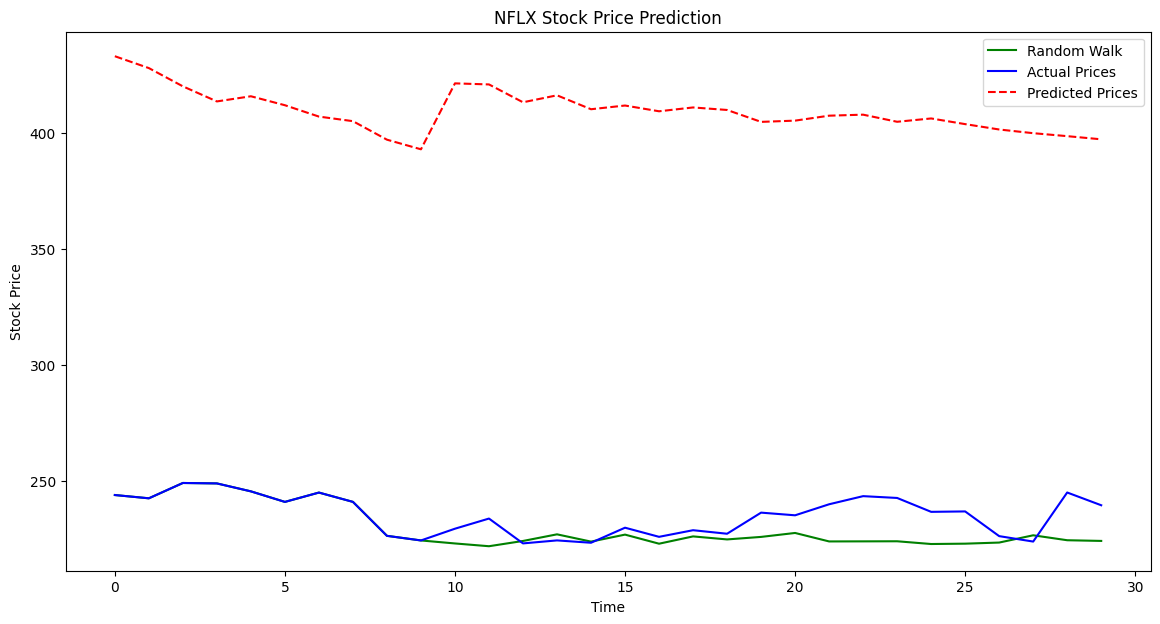

In [37]:
# Hyperparameter grid
window_sizes = [ 10] #5,
prediction_lengths = [15] #5 10,
lstm_units_options = [50]#, 100
batch_sizes = [32]#, 64
dropout_rates = [0.0]#, 0.2
predict_days = [20]
sents = [True,False]#

pred = np.zeros(30)

# Example usage
for i in range(10):
    for ticker in ['META', 'AMZN', 'AAPL','GOOG', 'NFLX']: #, 'META', 'AMZN', 'AAPL','GOOG', 'NFLX' 'TSLA'
        for window_size, prediction_length, lstm_units, batch_size, dropout_rate, predict_day, sent in product(
                window_sizes, prediction_lengths, lstm_units_options, batch_sizes, dropout_rates, predict_days, sents):

            print(f"Training with window_size={window_size}, prediction_length={prediction_length}, lstm_units={lstm_units}, batch_size={batch_size}, dropout_rate={dropout_rate}, predict_day={predict_day}")
            
            test_size = window_size + prediction_length
            if prediction_length - predict_day < 0:
                test_size += abs(prediction_length - predict_day)
            print(test_size)
            
            predictions, test_y, test_X, importances = train(data_sent, prices_hist, ticker, window_size=window_size, prediction_length=prediction_length, lstm_units=lstm_units, batch_size=batch_size, dropout_rate=dropout_rate, predict_days=test_size, sent=sent)
            predictions = np.array(list(test_X['Close'])[:window_size] + list(predictions[0]) + [i[-1] for i in predictions[1:]])[:window_size+predict_day]
            rmse = rmse_out(predictions[window_size:], list(test_y.reset_index(drop=True)['Close'])[window_size:window_size+predict_day])
            print(f"RMSE: {rmse}")

            n_steps = predict_day
            history = list(test_X['Close'])[:window_size]

            # Make the forecast with some variability (adjust variability_factor as needed)
            variability_factor = 0.2  # Adjust this parameter to control the amount of variability
            # forecast = list(test_X['Close'])[:window_size] + list(random_walk_forecast(history, n_steps, variability_factor))

            rmse_random_walk = rmse_out(list(test_y.reset_index(drop=True)['Close'])[window_size:window_size+predict_day], list(random_walk_forecast(history, n_steps, variability_factor)))
            print(f"RMSE Random Walk: {rmse_random_walk}")

            print(pred)
            print(predictions)
            pred = np.sum([pred, predictions], axis=0)

            
            #plot_predictions(list(test_y.reset_index(drop=True)['Close'])[:window_size+predict_day], predictions, list(test_X['Close'])[:window_size] + list(random_walk_forecast(history, n_steps, variability_factor)), ticker)

                    # Save result to JSON file
            result = {
                'ticker': ticker,
                'window_size': window_size,
                'prediction_length': prediction_length,
                'lstm_units': lstm_units,
                'batch_size': batch_size,
                'dropout_rate': dropout_rate,
                'predict_day': predict_day,
                'rmse': rmse,
                'rmse_random_walk': rmse_random_walk,
                'without_sentiment' : sent,
                'importances' : ' '.join([str(i) for i in importances]),
                'predictions' : ' '.join([str(i) for i in predictions])
            }
            append_to_json('training_results1.json', result)

pred = pred/40
rmse = rmse_out(pred[window_size:], list(test_y.reset_index(drop=True)['Close'])[window_size:window_size+predict_day])
print(f"RMSE: {rmse}")
plot_predictions(list(test_y.reset_index(drop=True)['Close'])[:window_size+predict_day], pred, list(test_X['Close'])[:window_size] + list(random_walk_forecast(history, n_steps, variability_factor)), ticker)


### Correlation of prices and sentiment

In [30]:
for stock in ['META', 'AMZN', 'AAPL','GOOG', 'NFLX', 'TSLA']:
    df_corr = df_for_inp(data_sent, prices_hist, stock)
    corrs = {'ticker': stock}
    for sent in ['positive', 'neutral', 'negative']:
        correlation = df_corr[sent].corr(df_corr['Close'])
        corrs[sent] = correlation
    print(corrs)

{'ticker': 'META', 'positive': 0.08740544078235996, 'neutral': 0.09643629866796304, 'negative': -0.21712226387373826}
{'ticker': 'AMZN', 'positive': 0.15634513880047135, 'neutral': -0.036205405941915576, 'negative': -0.18436085186132425}
{'ticker': 'AAPL', 'positive': 0.0994623609543123, 'neutral': -0.01946460457527111, 'negative': -0.10868631513777716}
{'ticker': 'GOOG', 'positive': 0.030823106440933758, 'neutral': -0.05485250234639411, 'negative': 0.023279072735494205}
{'ticker': 'NFLX', 'positive': 0.23148838284695858, 'neutral': -0.03149062271352068, 'negative': -0.2474097073275972}
{'ticker': 'TSLA', 'positive': 0.34345618919252324, 'neutral': -0.02993766523200747, 'negative': -0.4166752705828227}


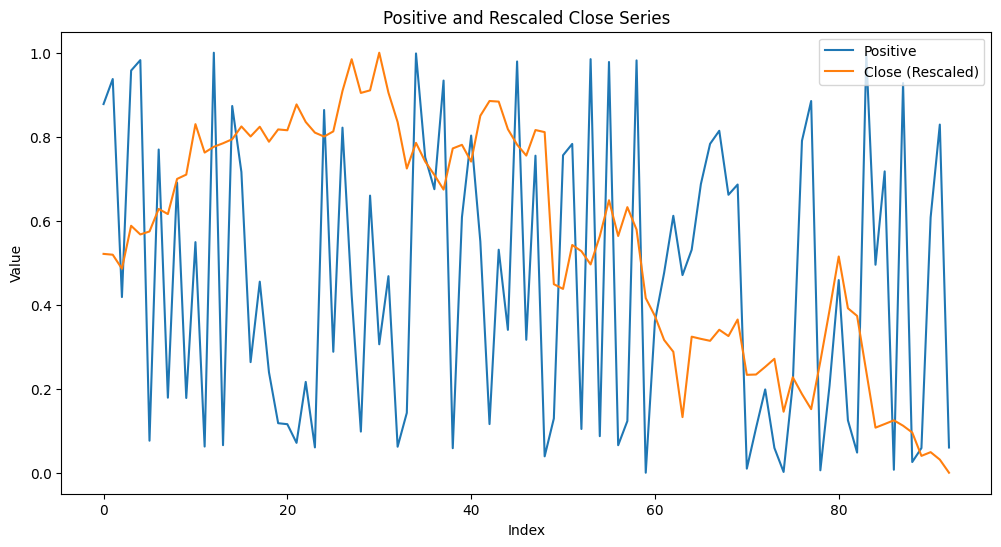

In [29]:
# Rescale the 'Close' series
scaler = MinMaxScaler()
df_corr['Close_rescaled'] = scaler.fit_transform(df_corr[['Close']])
df_corr['positive_rescaled'] = scaler.fit_transform(df_corr[['positive']])

# Plot both series
plt.figure(figsize=(12, 6))
plt.plot(df_corr.index, df_corr['positive_rescaled'], label='Positive')
plt.plot(df_corr.index, df_corr['Close_rescaled'], label='Close (Rescaled)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Positive and Rescaled Close Series')
plt.legend()
plt.show()